#### **Importing Libraries**

In [1]:
! pip install xgboost
from google.colab import files
uploaded = files.upload()
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split as tts, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score as acc,confusion_matrix as cm, classification_report as cr
from xgboost import XGBClassifier

Saving parkinsons.data to parkinsons.data
Mounted at /content/gdrive


#### **Importing Dataset**

In [2]:
df = pd.read_csv('parkinsons.data', delimiter=',')  # Adjust delimiter based on your data format
df.head(3)

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634


##### **Attribute Information:**

Matrix column entries (attributes):
name - ASCII subject name and recording number

**MDVP:Fo(Hz)** - Average vocal fundamental frequency

**MDVP:Fhi(Hz)** - Maximum vocal fundamental frequency

**MDVP:Flo(Hz)** - Minimum vocal fundamental frequency

**MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP** - Several measures of variation in fundamental frequency

**MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA **- Several measures of variation in amplitude

**NHR,HNR** - Two measures of ratio of noise to tonal components in the voice

**status** - Health status of the subject (one) - Parkinson's, (zero) - healthy

**RPDE,D2** - Two nonlinear dynamical complexity measures

**DFA** - Signal fractal scaling exponent

**spread1,spread2,PPE** - Three nonlinear measures of fundamental frequency variation

-----------------------------------------------------

**Citation Request:**

If you use this dataset, please cite the following paper:
'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection',
Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM.
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)

##### **Distribution of target variable**

Number of identified parkinsons: 147
Number of healthy subjects: 48


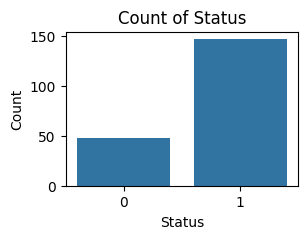

In [3]:
print('Number of identified parkinsons:',df[df['status'] == 1].shape[0])
print('Number of healthy subjects:',df[df['status'] == 0].shape[0])
plt.figure(figsize=(3, 2))
sns.barplot(df['status'].value_counts())
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Count of Status')
plt.show()

#### **Scaling**

Since the feature of data are at different scales which is similar to comparing apples with oranges, we need to scale them.

In [4]:
scaler=MinMaxScaler()
x=df.drop(['status','name'],axis=1) # dropping name and target variable
x=scaler.fit_transform(x)
y=df['status']

#### **Defining Function to train and evaluate**

 we will be using GridSearch, KFold, Cross Validation and various Classifiers to train and evaluate our model

In [5]:
def train_evaluate(x, y, param_grid=None, n_splits=5,classifier=None,model_name=None):
    # Using a random_state of 0 for reproducibility and startify so that the distribution of classes is the same in train and test
    x_train,x_test,y_train,y_test=tts(x,y,test_size=0.2,random_state=0,stratify=y)
    model = classifier

    if param_grid:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=n_splits)
        grid_search.fit(x_train, y_train)
        print("Best parameters: ", grid_search.best_params_)
        model = grid_search.best_estimator_

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, x_train, y_train, cv=kfold)
    print(f"Accuracy Score {model_name}:", np.round(acc(y_train, y_pred)*100,2), "%")
    print("Classification Report:\n", cr(y_train, y_pred))

    cm1 = cm(y_train, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix {model_name}")
    plt.show()

    model.fit(x_train, y_train)

    # Return the trained model
    return model

#### **XGBoost Classifier**

**Learning Rate:**
learning_rate is a hyperparameter that determines the step size at each iteration while moving toward a minimum of the loss function. A smaller learning rate generally leads to a more accurate model but requires more training time.

**Max Depth:**
max_depth controls the maximum depth of each tree in the boosting process. A deeper tree can capture more complex relationships in the data but may lead to overfitting.

**Number of Estimators:**
n_estimators is the number of boosting rounds, representing the number of trees in the ensemble. Increasing the number of trees can improve the model's performance up to a point, after which it may lead to overfitting or increased computational cost.

**Evaluation Metric:**
eval_metric specifies the evaluation metric to be used during the training process. In this case, 'auc' stands for Area Under the Receiver Operating Characteristic curve, and 'error' represents the classification error. The choice of metric depends on the specific problem and goals of the model.

Best parameters:  {'eval_metric': 'auc', 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Accuracy Score XGBoost: 89.74 %
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78        38
           1       0.93      0.94      0.93       118

    accuracy                           0.90       156
   macro avg       0.87      0.85      0.86       156
weighted avg       0.90      0.90      0.90       156



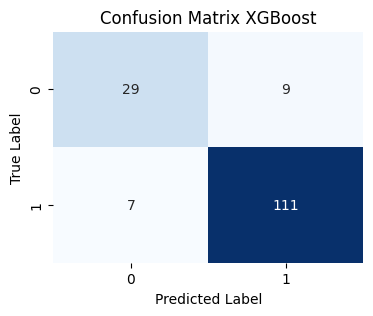

In [6]:
param_grid = {'learning_rate': [0.0001,0.001,0.01, 0.1, 0.2,0.3,0.4],
              'max_depth': range(1,20),
              'n_estimators': range(25,301,25),
              'eval_metric': ['auc', 'error']}
trained_model = train_evaluate(x, y, param_grid=param_grid, classifier=XGBClassifier(), model_name="XGBoost")

#### **GB Classifier**

Best parameters:  {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 175}
Accuracy Score Gradient Boosting: 91.03 %
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.76      0.81        38
           1       0.93      0.96      0.94       118

    accuracy                           0.91       156
   macro avg       0.89      0.86      0.87       156
weighted avg       0.91      0.91      0.91       156



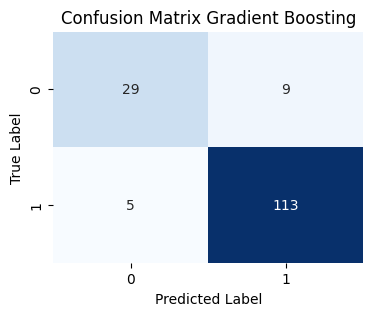

In [8]:
param_grid = {'learning_rate': [0.0001,0.001,0.01, 0.1, 0.2,0.3,0.4,0.5],
              'max_depth': range(1,20),
              'n_estimators': range(25,301,25)}
trained_model_GB = train_evaluate(x, y, param_grid=param_grid, classifier=GradientBoostingClassifier(), model_name="Gradient Boosting")

#### **Random Forest Classifier**

**max_depth:** Similar to the first grid, it represents the maximum depth of each tree in the ensemble.

**n_estimators:** Similar to the first grid, it represents the number of trees in the ensemble.

**criterion:** The function to measure the quality of a split. Options include 'gini' for Gini impurity and 'entropy' for information gain.

Best parameters:  {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 25}
Accuracy Score Random Forest: 86.54 %
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72        38
           1       0.91      0.92      0.91       118

    accuracy                           0.87       156
   macro avg       0.82      0.81      0.82       156
weighted avg       0.86      0.87      0.86       156



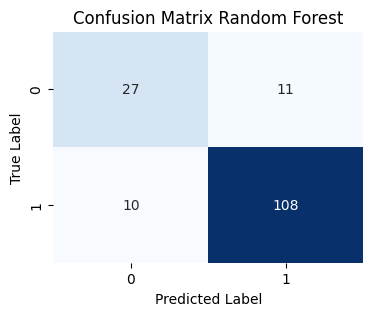

In [11]:
param_grid = {'max_depth': range(1,50),
              'n_estimators': range(25,301,25),
              'criterion': ['gini', 'entropy']}
trained_model_RF = train_evaluate(x, y, param_grid=param_grid, classifier=RandomForestClassifier(), model_name="Random Forest")